cv2.TM_CCOEFF_NORMED -0.5579040050506592 0.5580925941467285 (312, 148) (780, 45)
cv2.TM_CCORR_NORMED 0.5650643110275269 0.9598758220672607 (312, 123) (1003, 571)
cv2.TM_SQDIFF_NORMED 0.08358638733625412 1.0 (1003, 571) (300, 67)


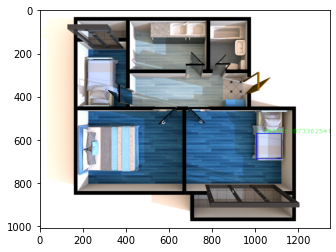

In [13]:


# 템플릿 매칭으로 객체 위치 검출 (template_matching.py)

import matplotlib.pyplot as plt
import cv2
import numpy as np

# 입력이미지와 템플릿 이미지 읽기
img = cv2.imread('/Users/reejungkim/Documents/Git/ImgProcessor/img/to_label/2_8.png')
template = cv2.imread('/Users/reejungkim/Documents/Git/ImgProcessor/img/src.png')
th, tw = template.shape[:2]
cv2.imshow('template', template)

# 3가지 매칭 메서드 순회
methods = ['cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR_NORMED', \
                                     'cv2.TM_SQDIFF_NORMED']
for i, method_name in enumerate(methods):
    img_draw = img.copy()
    method = eval(method_name)
    # 템플릿 매칭   ---①
    res = cv2.matchTemplate(img, template, method)
    # 최솟값, 최댓값과 그 좌표 구하기 ---②
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    print(method_name, min_val, max_val, min_loc, max_loc)

    # TM_SQDIFF의 경우 최솟값이 좋은 매칭, 나머지는 그 반대 ---③
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
        match_val = min_val
    else:
        top_left = max_loc
        match_val = max_val
    # 매칭 좌표 구해서 사각형 표시   ---④      
    bottom_right = (top_left[0] + tw, top_left[1] + th)
    cv2.rectangle(img_draw, top_left, bottom_right, (0,0,255),2)
    # 매칭 포인트 표시 ---⑤
    cv2.putText(img_draw, str(match_val), top_left, \
                cv2.FONT_HERSHEY_PLAIN, 2,(0,255,0), 1, cv2.LINE_AA)
    #cv2.imshow(method_name, img_draw)
plt.imshow(img_draw)

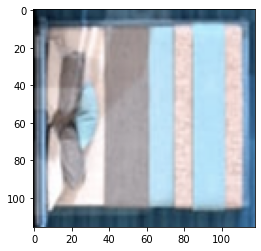

In [35]:
plt.imshow(cv2.rotate(cv2.imread('/Users/reejungkim/Documents/Git/ImgProcessor/img/src.png'), cv2.ROTATE_90_CLOCKWISE))

In [39]:
 #매칭점 원근 변환으로 영역 찾기 (match_homography.py)
img1 = cv2.imread('/Users/reejungkim/Documents/Git/ImgProcessor/img/src3.png')
img2 = cv2.imread('/Users/reejungkim/Documents/Git/ImgProcessor/img/to_label/2_8.png')

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# ORB, BF-Hamming 로 knnMatch  ---①
detector = cv2.ORB_create()
kp1, desc1 = detector.detectAndCompute(gray1, None)
kp2, desc2 = detector.detectAndCompute(gray2, None)
matcher = cv2.BFMatcher(cv2.NORM_HAMMING2)
matches = matcher.knnMatch(desc1, desc2, 2)

# 이웃 거리의 75%로 좋은 매칭점 추출---②
ratio = 0.75
good_matches = [first for first,second in matches \
                    if first.distance < second.distance * ratio]
print('good matches:%d/%d' %(len(good_matches),len(matches)))



good matches:0/99


In [40]:

# 좋은 매칭점의 queryIdx로 원본 영상의 좌표 구하기 ---③
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ])
# 좋은 매칭점의 trainIdx로 대상 영상의 좌표 구하기 ---④
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ])
# 원근 변환 행렬 구하기 ---⑤
mtrx, mask = cv2.findHomography(src_pts, dst_pts)
# 원본 영상 크기로 변환 영역 좌표 생성 ---⑥
h,w, = img1.shape[:2]
pts = np.float32([ [[0,0]],[[0,h-1]],[[w-1,h-1]],[[w-1,0]] ])
# 원본 영상 좌표를 원근 변환  ---⑦
dst = cv2.perspectiveTransform(pts,mtrx)
# 변환 좌표 영역을 대상 영상에 그리기 ---⑧
img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

# 좋은 매칭 그려서 출력 ---⑨
res = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, \
                    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
plt.imshow(res)

error: OpenCV(4.6.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/calib3d/src/fundam.cpp:378: error: (-5:Bad argument) The input arrays should be 2D or 3D point sets in function 'findHomography'
